<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/NeuralNetworks/CategorizingFaces.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMU Faces Dataset

In 1997 Tom Mitchell wrote one of the first textbooks on machine learning appropriately titled **Machine Learning** [1]. Along with the book he provided a dataset of faces to allow readers to experiment with neural networks. This dataset is quite small by today's standards, but it will allow us to explore a variety of classification tasks using relatively small network models.

The dataset contains images depicting 20 different individuals, displaying various emotions (neutral, happy, sad, or angry), facing different directions (forward, right, left, up), and either wearing sunglasses or not. Each image is 120 by 128 for a total of 15,360 pixels.

Let's begin by installing all of the software we will need.

In [1]:
%pip install aitk --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.3/310.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.6 MB/s eta 0:00:00


In [2]:
from aitk.networks import SequentialNetwork
import numpy as np
from aitk.utils import array_to_image, get_dataset, gallery
from time import sleep

Next we will download the dataset of faces.

In [3]:
ds = get_dataset("cmu-faces")

4332797952it [00:00, 13805926034.37it/s]


Let's find out how many images are contained in this dataset.

In [4]:
len(ds.train_inputs)

624

Let's look at how all of the features of the data are encoded. We will just inspect the first 20 images in the dataset.

- The first feature is the unique name of a person.
- The second feature is the direction they are facing.
- The third feature is the emotion they are displaying.
- Finally, the last feature is whether they are wearing sunglasses.

In [5]:
ds.train_features[:20]

[['quinn', 'right', 'sad', 'sunglasses'],
 ['quinn', 'up', 'angry', 'eyes'],
 ['quinn', 'up', 'angry', 'sunglasses'],
 ['quinn', 'up', 'happy', 'eyes'],
 ['quinn', 'up', 'happy', 'sunglasses'],
 ['quinn', 'up', 'neutral', 'eyes'],
 ['quinn', 'up', 'neutral', 'sunglasses'],
 ['quinn', 'up', 'sad', 'eyes'],
 ['quinn', 'up', 'sad', 'sunglasses'],
 ['rose', 'forward', 'angry', 'eyes'],
 ['rose', 'forward', 'angry', 'sunglasses'],
 ['rose', 'forward', 'happy', 'eyes'],
 ['rose', 'forward', 'happy', 'sunglasses'],
 ['rose', 'forward', 'neutral', 'eyes'],
 ['rose', 'forward', 'neutral', 'sunglasses'],
 ['rose', 'forward', 'sad', 'eyes'],
 ['rose', 'forward', 'sad', 'sunglasses'],
 ['rose', 'left', 'angry', 'eyes'],
 ['rose', 'left', 'angry', 'sunglasses'],
 ['rose', 'left', 'happy', 'eyes']]

# Classification Task: Sunglasses or not?

Let's extract a subset of images from the original dataset. We will focus on only the images showing people facing forward and try to determine whether or not they are wearing sunglasses. We will call this subset *glasses*.



In [6]:
glasses = ds.query_train(includes=["forward"])

In [7]:
glasses.train_features[:10]

[['rose', 'forward', 'angry', 'eyes'],
 ['rose', 'forward', 'angry', 'sunglasses'],
 ['rose', 'forward', 'happy', 'eyes'],
 ['rose', 'forward', 'happy', 'sunglasses'],
 ['rose', 'forward', 'neutral', 'eyes'],
 ['rose', 'forward', 'neutral', 'sunglasses'],
 ['rose', 'forward', 'sad', 'eyes'],
 ['rose', 'forward', 'sad', 'sunglasses'],
 ['sam', 'forward', 'angry', 'eyes'],
 ['sam', 'forward', 'angry', 'sunglasses']]

In [8]:
len(glasses.train_inputs)

156

Here are the first 10 images from the glasses dataset. The display will show images of people's faces, alternating with and without sunglasses.

0,1,2,3
4,5,6,7
8,9,,

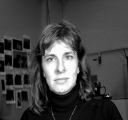
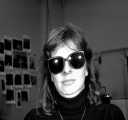
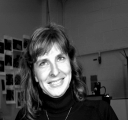
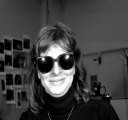
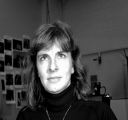
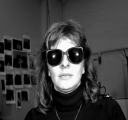
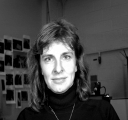
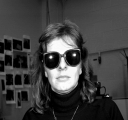
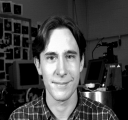
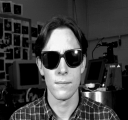

In [9]:
images = [array_to_image(glasses.train_inputs[i]) for i in range(0,10)]
gallery(images)

Next we need to determine the targets for training this task. Any images with the label "eyes" we will train the network to output [1,0], and any images with the label "sunglasses" we will train the network to output [0,1]. This is known as a one-hot encoding.

In [10]:
glasses.train_targets = []
for i in range(len(glasses.train_features)):
  if "eyes" in glasses.train_features[i]:
    glasses.train_targets.append([1,0])
  elif "sunglasses" in glasses.train_features[i]:
    glasses.train_targets.append([0,1])
  else:
    raise ValueError("pattern %d should not be in this dataset" %(i))

Here are the first 10 targets for training, and we can see that they are correctly encoding the desired output for the first 10 images displayed above.

In [11]:
glasses.train_targets[:10]

[[1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1]]

## Building the neural network

The network must take images that are 120x128 as input and produce 2 outputs. What goes in between the input and output layers is up to the model builder. This is a relatively simple task, so let's start with a very small hidden layer of size 3.

Also, by choosing such a small hidden layer we will be able to easily visualize the weights learned by the network after training is complete.

The network summary shows us the total number of trainable parameters in this neural network, which for this particular network is approximately 46 thousand. For modern networks the number of trainable parameters may be in the billions.

In [12]:
net = SequentialNetwork(
          (120,128),
          "Flatten",
          3,
          (2, "softmax")
      )
net.summary()

Model: "SequentialNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15360)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_2 (Dense)                     │ (None, 3)                   │          46,083 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,091 (180.04 KB)

 Trainable params: 46,091 (180.04 KB)

 Non-trainable params: 0 (0.00 B)

## Training on sunglasses task

Each time you recreate the network (using the cell above) it will start with a different set of random weights. In most cases the network will successfully solve the task. However, because we chose such a small hidden layer, in some cases it will get stuck. Simply rerun the cell above to recreate the network, and then train it by executing the cell below.

In [13]:
net.fit(
    glasses.train_inputs, glasses.train_targets,
    batch_size=32,
    report_rate=10,
    epochs=150,
    accuracy=1.0
)

Stopped because accuracy beat goal of 1.0
Epoch 48/150 loss: 0.0016903316136449575 - tolerance_accuracy: 1.0


## Testing on sunglasses task

Let's watch how the trained network classifies the images.Watch the hidden layer activations. Are all of them lighting up white or only some of them? Is there a pattern that they follow based on whether the person is wearing sunglasses or not?


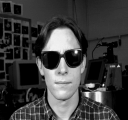

In [14]:
for i in range(10):
  net.display(glasses.train_inputs[i])
  sleep(1.0)

## Weights learned on sunglasses task

Neural networks are often described as black boxes because it is hard to understand *how* they have learned to solve a particular task.

However, for this simple model applied to an image classification task we can actually visualize how the network has modified its weights in order to solve the problem. To determine whether each person in the image is wearing sunglasses or not, the network must learn to focus on the eye area of the face.

There are 3 hidden layer neurons. Let's see how each one of these hidden neurons has weighted its connections to the input image. Each pixel in the visualizations below represents one weight from the input image to the hidden neuron. The darker the color the lower the weight, the lighter the color the higher the weight.

Each time you retrain the network it may discover a different way to successfully classify the images. In some runs you may find that one or two of the hidden units is largely ignored, and it's weights will look like random noise.

In [15]:
def show_hidden_weights(network, i):
  image = array_to_image(network.get_weights()[0][:,i].reshape((120, 128)))
  return image.resize((240, 256), resample=0)

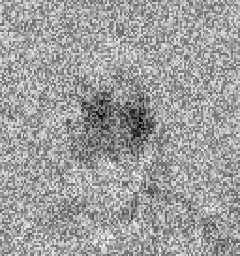

In [16]:
show_hidden_weights(net, 0)

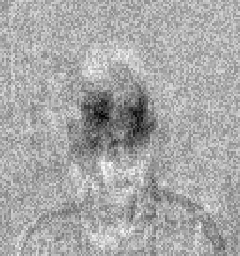

In [17]:
show_hidden_weights(net, 1)

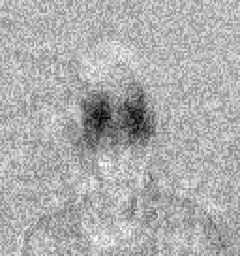

In [18]:
show_hidden_weights(net, 2)

# Classification task: Direction straight, left, or right?

Now let's try a different classification task to determine which direction a person is facing in each image. Let's focus on images without sunglasses, and let's also exclude the direction up.

We will go through all of the same steps again to extract the desired images into a new dataset, this time called *direction*. Then we will check its size, look at some sample images, verify the features, and create the training targets.

In [19]:
direction = ds.query_train(includes = ["eyes"], excludes = ["up"])

In [20]:
len(direction.train_inputs)

234

Here are the first 10 images from the directions dataset. It should show several images of a feminine presenting person with varying facial expressions.

0,1,2,3
4,5,6,7
8,9,,

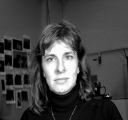
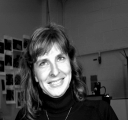
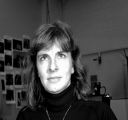
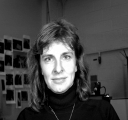
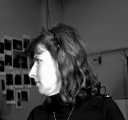
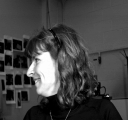
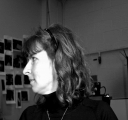
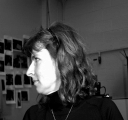
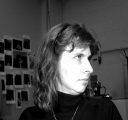
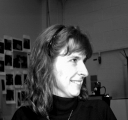

In [21]:
images = [array_to_image(direction.train_inputs[i]) for i in range(0,10)]
gallery(images)

In [22]:
direction.train_features[:10]

[['rose', 'forward', 'angry', 'eyes'],
 ['rose', 'forward', 'happy', 'eyes'],
 ['rose', 'forward', 'neutral', 'eyes'],
 ['rose', 'forward', 'sad', 'eyes'],
 ['rose', 'left', 'angry', 'eyes'],
 ['rose', 'left', 'happy', 'eyes'],
 ['rose', 'left', 'neutral', 'eyes'],
 ['rose', 'left', 'sad', 'eyes'],
 ['rose', 'right', 'angry', 'eyes'],
 ['rose', 'right', 'happy', 'eyes']]

We want the network to classify each image as either facing foward, left, or right. We will use a one-hot encoding of length three to accomplish this.

In [23]:
direction.train_targets = []
for i in range(len(direction.train_features)):
  if "forward" in direction.train_features[i]:
    direction.train_targets.append([1,0,0])
  elif "left" in direction.train_features[i]:
    direction.train_targets.append([0,1,0])
  elif "right" in direction.train_features[i]:
    direction.train_targets.append([0,0,1])
  else:
    raise ValueError("pattern %d should not be in this dataset" %(i))

In [24]:
direction.train_targets[:10]

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 0, 1],
 [0, 0, 1]]

## Building the neural network

This network is very similar to our original network, but we need to make the output layer have 3 outputs for the 3 possible directions.

In [25]:
net2 = SequentialNetwork(
          (120,128),
          "Flatten",
          3,
          (3, "softmax")
      )
net2.summary()

Model: "SequentialNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 120, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15360)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_2 (Dense)                     │ (None, 3)                   │          46,083 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 3)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,095 (180.06 KB)

 Trainable params: 46,095 (180.06 KB)

 Non-trainable params: 0 (0.00 B)

## Training on direction task

Remember that you can recreate the network as many times as you'd like by rerunning the cell above. This is a harder task than whether someone is wearing sunglasses, so in some runs the network may not be able to learn the task from the random starting conditions. In those cases, just try again by re-running the cell above and the cell below.

In [26]:
net2.fit(
    direction.train_inputs, direction.train_targets,
    batch_size=32,
    report_rate=100,
    epochs=150,
    accuracy=1.0
)

Stopped because accuracy beat goal of 1.0
Epoch 111/150 loss: 0.0007461365894414485 - tolerance_accuracy: 1.0


## Testing on direction task

Again, let's watch how the trained network classifies the images. Which hidden layer units light up for the different directions the person is facing?



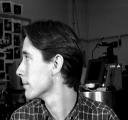

In [27]:
from time import sleep
for i in range(20):
  net2.display(direction.train_inputs[i])
  outputs = net2.propagate(direction.train_inputs[i])
  sleep(1.0)

## Weights learned on direction task

Next let's examine the weights and see if we can understand more about how the network has solved the task given the pattern of hidden unit acitivations that you observed.

In order to solve this task the network has to learn how to recognize the direction a person is facing. Perhaps it focuses on the profile or maybe the neck area or a combination of the two. Let's find out.


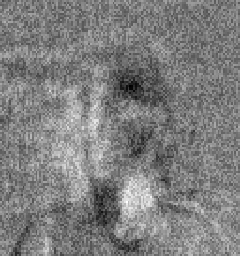

In [28]:
show_hidden_weights(net2, 0)

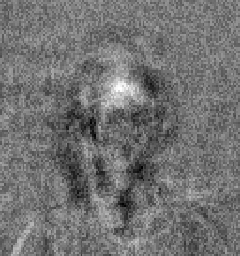

In [29]:
show_hidden_weights(net2, 1)

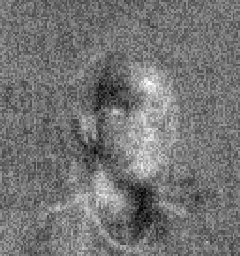

In [30]:
show_hidden_weights(net2, 2)

# Issues with Categorization

In Kate Crawford's book [2], she argues that every dataset used to train machine learning systems has a worldview:

"To create a training set is to take an almost infinitely complex and varied world and fix it into taxonomies composed of discrete classifications of individual data points, a process that requires inherently political, cultural, and social choices. By paying attention to these classifications, we can glimpse the various forms of power that are built into the architectures of AI world building" (pgs. 135-136).

Here are some questions to consider with respect to the faces data set we used in this notebook:

* Do you think it was collected with the participants' consent and did they likely know it would be made publicly available?
* How diverse is the dataset in terms of gender, race, age, etc.?
* Is emotion something that is easily recognized in someone's facial expressions?
* What do you notice about how these images were posed?
* How well do you expect classifiers trained on this dataset would generalize to novel images that were not posed in the same way?


# Conclusion

Most modern classification problems are much more complex than the ones we've explored here, involving hundreds of thousands of images and using networks with many more layers of neurons.

We hope that by exploring these relatively simple classification tasks that you've gained a better understanding of how the hidden layer of a neural network is able to learn how to interpret the data in order to help it solve a classification task.

# References

[1] Tom Mitchell (1977). *Machine Learning*, McGraw-Hill.

[2] Kate Crawford (2021). *Atlas of AI*, Yale University Press.